# Parsing MIDI Files: Three Different Approaches

In this notebook, we'll explore three different Python libraries for working with MIDI files: 
1. **pretty_midi** - High-level interface focused on musical content
2. **mido** - Low-level interface for MIDI messages
3. **pypianoroll** - Piano roll representation for multi-track music

Each library offers different perspectives and use cases for symbolic music processing.

## Setup 
First, let's install the required libraries and import them:

`!pip install pretty_midi mido pypianoroll`


In [2]:
# Import all the libraries we'll use in the notebook
import os
from pathlib import Path

import matplotlib.pyplot as plt
import mido
import numpy as np
import pretty_midi
import pypianoroll


In [8]:
# Set up the dataset path
MIDI_DATASET_PATH = Path("../data/midi")
print(f"MIDI dataset path: {MIDI_DATASET_PATH.resolve()}")

# Get a list of all MIDI files
midi_files = list(MIDI_DATASET_PATH.glob("*.mid"))
print(f"Found {len(midi_files)} MIDI files in the dataset")

# We'll use the first file for demonstrations
if midi_files:
    example_file = midi_files[0]
    print(f"Using example file: {example_file.name}")
else:
    print("No MIDI files found! Please add some MIDI files to the midi_dataset folder.")

MIDI dataset path: /Users/andreapoltronieri/Documents/Projects/SyMP-CM/2026/data/midi
Found 199 MIDI files in the dataset
Using example file: Step_Inside_Love_Los_Paranoias.1.mid


## 1. mido: Low-Level MIDI Message Interface
 
`mido` works with raw MIDI messages, giving you complete control over the MIDI format.

 
**Documentation:** https://mido.readthedocs.io/en/latest/


In [16]:
# Load a MIDI file with mido
mid = mido.MidiFile(str(example_file))

# Basic information
print(f"File: {example_file.name}")
print(f"MIDI Type: {mid.type}")
print(f"Number of tracks: {len(mid.tracks)}")
print(f"Ticks per beat: {mid.ticks_per_beat}")
print(f"Total length: {mid.length:.2f} seconds")

File: Step_Inside_Love_Los_Paranoias.1.mid
MIDI Type: 1
Number of tracks: 10
Ticks per beat: 120
Total length: 53.30 seconds


In [17]:
# Show messages from the first track
print("\nFirst 20 messages from track 0:")
for i, msg in enumerate(mid.tracks[0][:20]):
    print(f"  {i}: {msg}")



First 20 messages from track 0:
  0: MetaMessage('key_signature', key='C', time=0)
  1: MetaMessage('smpte_offset', frame_rate=30, hours=0, minutes=0, seconds=0, frames=0, sub_frames=0, time=0)
  2: MetaMessage('set_tempo', tempo=483870, time=0)
  3: MetaMessage('time_signature', numerator=4, denominator=4, clocks_per_click=24, notated_32nd_notes_per_beat=8, time=0)
  4: MetaMessage('end_of_track', time=0)


In [18]:
# Count different message types across all tracks
message_types = {}
for track in mid.tracks:
    for msg in track:
        msg_type = msg.type
        message_types[msg_type] = message_types.get(msg_type, 0) + 1

print("Message type distribution:")
for msg_type, count in sorted(message_types.items(), key=lambda x: x[1], reverse=True):
    print(f"  {msg_type}: {count}")

Message type distribution:
  note_on: 1648
  control_change: 617
  end_of_track: 10
  midi_port: 9
  track_name: 9
  program_change: 3
  key_signature: 1
  smpte_offset: 1
  set_tempo: 1
  time_signature: 1


In [19]:
def extract_notes_from_mido(midi_path):
    """Extract note events with timing information"""
    mid = mido.MidiFile(str(midi_path))

    notes = []
    for track_idx, track in enumerate(mid.tracks):
        current_time = 0
        active_notes = {}  # pitch -> start_time

        for msg in track:
            current_time += msg.time

            if msg.type == "note_on" and msg.velocity > 0:
                # Note starts
                active_notes[msg.note] = {
                    "start": current_time,
                    "velocity": msg.velocity,
                    "channel": msg.channel,
                }
            elif msg.type == "note_off" or (
                msg.type == "note_on" and msg.velocity == 0
            ):
                # Note ends
                if msg.note in active_notes:
                    note_info = active_notes.pop(msg.note)
                    notes.append({
                        "track": track_idx,
                        "pitch": msg.note,
                        "start": note_info["start"],
                        "end": current_time,
                        "duration": current_time - note_info["start"],
                        "velocity": note_info["velocity"],
                        "channel": note_info["channel"],
                    })

    return notes


# Extract notes
notes = extract_notes_from_mido(example_file)
print(f"\nExtracted {len(notes)} notes from {example_file.name}")

if notes:
    print("\nFirst 5 notes:")
    for note in notes[:5]:
        note_name = pretty_midi.note_number_to_name(note["pitch"])
        print(
            f"  Pitch: {note['pitch']} ({note_name}), "
            f"Start: {note['start']:.2f}, Duration: {note['duration']:.2f}, "
            f"Velocity: {note['velocity']}, Track: {note['track']}"
        )



Extracted 824 notes from Step_Inside_Love_Los_Paranoias.1.mid

First 5 notes:
  Pitch: 62 (D4), Start: 2098.00, Duration: 67.00, Velocity: 111, Track: 1
  Pitch: 62 (D4), Start: 2218.00, Duration: 85.00, Velocity: 99, Track: 1
  Pitch: 60 (C4), Start: 2331.00, Duration: 29.00, Velocity: 90, Track: 1
  Pitch: 60 (C4), Start: 2397.00, Duration: 105.00, Velocity: 102, Track: 1
  Pitch: 62 (D4), Start: 2512.00, Duration: 41.00, Velocity: 97, Track: 1


In [20]:
def ticks_to_seconds(ticks, ticks_per_beat, tempo):
    """Convert MIDI ticks to seconds

    Args:
        ticks: Number of ticks
        ticks_per_beat: Ticks per quarter note (from MIDI file)
        tempo: Microseconds per quarter note (default: 500000 = 120 BPM)
    """
    return (ticks * tempo) / (ticks_per_beat * 1_000_000)


# Extract tempo information
mid = mido.MidiFile(str(example_file))
current_tempo = 500000  # Default: 120 BPM

print("Tempo changes in the file:")
for track in mid.tracks:
    for msg in track:
        if msg.type == "set_tempo":
            bpm = mido.tempo2bpm(msg.tempo)
            print(f"  Tempo: {msg.tempo} microseconds/beat = {bpm:.1f} BPM")
            current_tempo = msg.tempo

Tempo changes in the file:
  Tempo: 483870 microseconds/beat = 124.0 BPM


In [21]:
# Create a simple C major scale
new_mid = mido.MidiFile()
track = mido.MidiTrack()
new_mid.tracks.append(track)

# Add track name and tempo
track.append(mido.MetaMessage("track_name", name="C Major Scale", time=0))
track.append(mido.MetaMessage("set_tempo", tempo=500000, time=0))  # 120 BPM

# C major scale: C, D, E, F, G, A, B, C
c_major_scale = [60, 62, 64, 65, 67, 69, 71, 72]  # MIDI note numbers

# Add notes (quarter notes at 480 ticks per beat)
ticks_per_quarter = 480
for note_num in c_major_scale:
    track.append(mido.Message("note_on", note=note_num, velocity=64, time=0))
    track.append(
        mido.Message("note_off", note=note_num, velocity=64, time=ticks_per_quarter)
    )

# Save the file
output_path = MIDI_DATASET_PATH / "c_major_scale.mid"
new_mid.save(str(output_path))
print(f"Created new MIDI file: {output_path}")

Created new MIDI file: ../data/midi/c_major_scale.mid


## 2. pretty_midi: High-Level Musical Interface

`pretty_midi` provides an intuitive, object-oriented interface focused on musical concepts like notes, instruments, and tempo.

**Documentation:** https://craffel.github.io/pretty-midi/

In [23]:
# Load a MIDI file with pretty_midi
pm = pretty_midi.PrettyMIDI(str(example_file))

# Basic information
print(f"File: {example_file.name}")
print(f"Duration: {pm.get_end_time():.2f} seconds")
print(f"Tempo changes: {len(pm.get_tempo_changes()[0])}")
print(f"Number of instruments: {len(pm.instruments)}")
print()

# Explore instruments
for i, instrument in enumerate(pm.instruments):
    print(f"Instrument {i}:")
    print(
        f"  Program: {instrument.program} ({pretty_midi.program_to_instrument_name(instrument.program)})"
    )
    print(f"  Is drum: {instrument.is_drum}")
    print(f"  Number of notes: {len(instrument.notes)}")
    if instrument.notes:
        print(
            f"  Pitch range: {min(n.pitch for n in instrument.notes)} - {max(n.pitch for n in instrument.notes)}"
        )


File: Step_Inside_Love_Los_Paranoias.1.mid
Duration: 53.30 seconds
Tempo changes: 1
Number of instruments: 7

Instrument 0:
  Program: 91 (Pad 4 (choir))
  Is drum: False
  Number of notes: 61
  Pitch range: 55 - 69
Instrument 1:
  Program: 25 (Acoustic Guitar (steel))
  Is drum: False
  Number of notes: 279
  Pitch range: 48 - 67
Instrument 2:
  Program: 0 (Acoustic Grand Piano)
  Is drum: True
  Number of notes: 198
  Pitch range: 69 - 69
Instrument 3:
  Program: 0 (Acoustic Grand Piano)
  Is drum: True
  Number of notes: 59
  Pitch range: 75 - 75
Instrument 4:
  Program: 0 (Acoustic Grand Piano)
  Is drum: True
  Number of notes: 154
  Pitch range: 63 - 63
Instrument 5:
  Program: 53 (Voice Oohs)
  Is drum: False
  Number of notes: 19
  Pitch range: 62 - 74
Instrument 6:
  Program: 0 (Acoustic Grand Piano)
  Is drum: True
  Number of notes: 54
  Pitch range: 82 - 82


In [24]:
# Access notes from the first instrument
if pm.instruments and pm.instruments[0].notes:
    instrument = pm.instruments[0]

    # Show first 10 notes
    print("First 10 notes:")
    for note in instrument.notes[:10]:
        print(
            f"  Pitch: {note.pitch} ({pretty_midi.note_number_to_name(note.pitch)}), "
            f"Start: {note.start:.2f}s, End: {note.end:.2f}s, Velocity: {note.velocity}"
        )

    # Note statistics
    pitches = [note.pitch for note in instrument.notes]
    durations = [note.end - note.start for note in instrument.notes]
    velocities = [note.velocity for note in instrument.notes]

    print(f"\nNote statistics:")
    print(f"  Mean pitch: {np.mean(pitches):.1f}")
    print(f"  Mean duration: {np.mean(durations):.3f}s")
    print(f"  Mean velocity: {np.mean(velocities):.1f}")

First 10 notes:
  Pitch: 62 (D4), Start: 8.46s, End: 8.73s, Velocity: 111
  Pitch: 62 (D4), Start: 8.94s, End: 9.29s, Velocity: 99
  Pitch: 60 (C4), Start: 9.40s, End: 9.52s, Velocity: 90
  Pitch: 60 (C4), Start: 9.67s, End: 10.09s, Velocity: 102
  Pitch: 62 (D4), Start: 10.13s, End: 10.29s, Velocity: 97
  Pitch: 60 (C4), Start: 12.33s, End: 12.57s, Velocity: 106
  Pitch: 62 (D4), Start: 12.75s, End: 13.09s, Velocity: 103
  Pitch: 60 (C4), Start: 13.21s, End: 13.33s, Velocity: 100
  Pitch: 60 (C4), Start: 13.48s, End: 13.71s, Velocity: 106
  Pitch: 62 (D4), Start: 16.21s, End: 16.50s, Velocity: 104

Note statistics:
  Mean pitch: 61.1
  Mean duration: 0.271s
  Mean velocity: 100.9


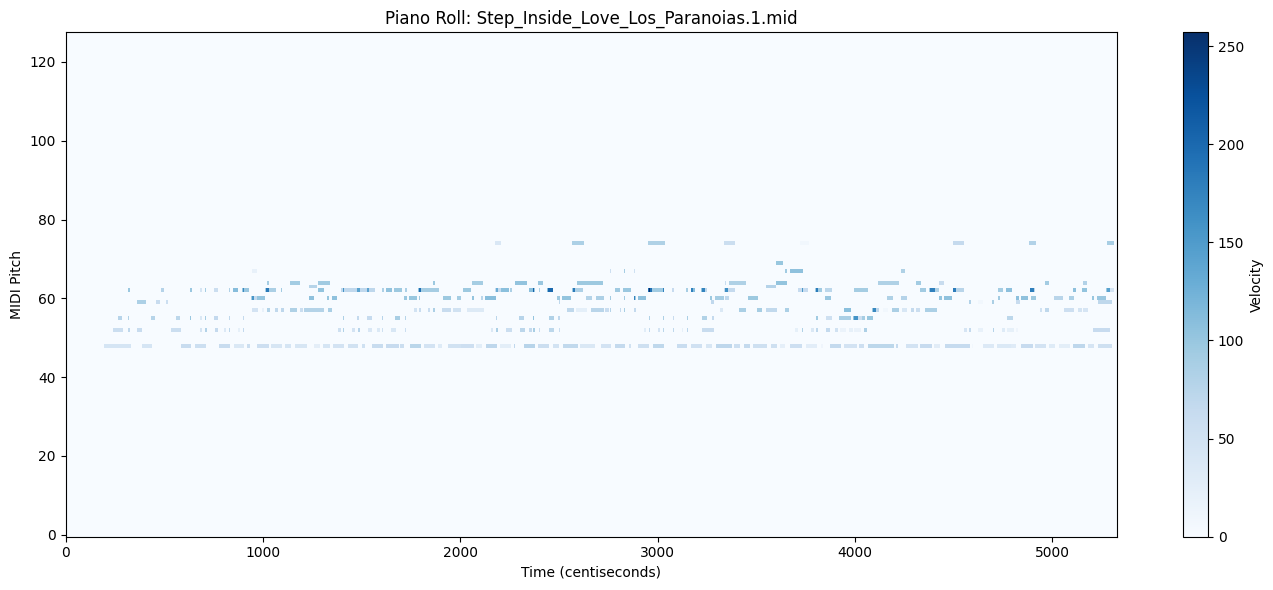

In [ ]:
# Create a piano roll visualization
if pm.instruments:
    plt.figure(figsize=(14, 6))

    # Get piano roll (128 pitches x time_steps)
    piano_roll = pm.get_piano_roll(fs=100)  # 100 Hz sampling rate

    # Plot
    plt.imshow(
        piano_roll, aspect="auto", origin="lower", cmap="Blues", interpolation="nearest"
    )
    plt.colorbar(label="Velocity")
    plt.xlabel("Time (centiseconds)")
    plt.ylabel("MIDI Pitch")
    plt.title(f"Piano Roll: {example_file.name}")
    plt.tight_layout()
    plt.show()


In [26]:
def analyze_midi_with_pretty_midi(midi_path):
    """Extract various musical features from a MIDI file"""
    pm = pretty_midi.PrettyMIDI(str(midi_path))

    features = {
        "duration": pm.get_end_time(),
        "num_instruments": len(pm.instruments),
        "tempo_changes": len(pm.get_tempo_changes()[0]),
        "time_signature_changes": len(pm.time_signature_changes),
    }

    # Aggregate note information across all instruments
    all_notes = []
    for instrument in pm.instruments:
        if not instrument.is_drum:
            all_notes.extend(instrument.notes)

    if all_notes:
        features["num_notes"] = len(all_notes)
        features["pitch_range"] = max(n.pitch for n in all_notes) - min(
            n.pitch for n in all_notes
        )
        features["mean_velocity"] = np.mean([n.velocity for n in all_notes])
        features["note_density"] = (
            len(all_notes) / pm.get_end_time()
        )  # notes per second

    return features


# Analyze all MIDI files
print("Analyzing all MIDI files in dataset:")
for midi_file in midi_files[:5]:  # Show first 5
    features = analyze_midi_with_pretty_midi(midi_file)
    print(f"\n{midi_file.name}:")
    for key, value in features.items():
        print(
            f"  {key}: {value:.2f}" if isinstance(value, float) else f"  {key}: {value}"
        )


Analyzing all MIDI files in dataset:

Step_Inside_Love_Los_Paranoias.1.mid:
  duration: 53.30
  num_instruments: 7
  tempo_changes: 1
  time_signature_changes: 1
  num_notes: 359
  pitch_range: 26
  mean_velocity: 70.45
  note_density: 6.74

Saturday_In_The_Park.4.mid:
  duration: 246.27
  num_instruments: 11
  tempo_changes: 1
  time_signature_changes: 1
  num_notes: 5353
  pitch_range: 58
  mean_velocity: 108.50
  note_density: 21.74

And_I_Love_Her.1.mid:
  duration: 160.10
  num_instruments: 10
  tempo_changes: 1
  time_signature_changes: 1
  num_notes: 1195
  pitch_range: 51
  mean_velocity: 80.01
  note_density: 7.46

Sei_un_mito.1.mid:
  duration: 299.26
  num_instruments: 8
  tempo_changes: 1
  time_signature_changes: 1
  num_notes: 4523
  pitch_range: 65
  mean_velocity: 95.79
  note_density: 15.11

Bad_to_the_Bone.mid:
  duration: 260.01
  num_instruments: 16
  tempo_changes: 1
  time_signature_changes: 1
  num_notes: 3359
  pitch_range: 68
  mean_velocity: 83.87
  note_densi

## 3. pypianoroll: Multi-Track Piano Roll Representation
 
`pypianoroll` represents music as piano rolls, which is particularly useful for deep learning applications.
 
**Documentation:** https://pypianoroll.readthedocs.io/en/latest/

In [9]:
# Load a MIDI file with pypianoroll
multitrack = pypianoroll.read(str(example_file))

# Basic information
print(f"File: {example_file.name}")
print(f"Resolution: {multitrack.resolution} ticks per quarter note")
print(f"Tempo: {multitrack.tempo}")
print(f"Number of tracks: {len(multitrack.tracks)}")
print(f"Length: {len(multitrack)} time steps")
print()

# Track information
for i, track in enumerate(multitrack.tracks):
    print(f"Track {i}: {track.name}")
    print(f"  Program: {track.program}")
    print(f"  Is drum: {track.is_drum}")
    print(f"  Pianoroll shape: {track.pianoroll.shape}")  # (time_steps, 128)
    if track.pianoroll.sum() > 0:
        active_pitches = np.where(track.pianoroll.sum(axis=0) > 0)[0]
        print(f"  Active pitch range: {active_pitches.min()} - {active_pitches.max()}")


File: Step_Inside_Love_Los_Paranoias.1.mid
Resolution: 24 ticks per quarter note
Tempo: [[124.000248]
 [124.000248]
 [124.000248]
 ...
 [124.000248]
 [124.000248]
 [124.000248]]
Number of tracks: 7
Length: 7 time steps

Track 0: VOCAL
  Program: 91
  Is drum: False
  Pianoroll shape: (2664, 128)
  Active pitch range: 55 - 69
Track 1: GUITAR
  Program: 25
  Is drum: False
  Pianoroll shape: (2664, 128)
  Active pitch range: 48 - 67
Track 2: MARRACAS
  Program: 0
  Is drum: True
  Pianoroll shape: (2664, 128)
  Active pitch range: 69 - 69
Track 3: CLAVES
  Program: 0
  Is drum: True
  Pianoroll shape: (2664, 128)
  Active pitch range: 75 - 75
Track 4: CONGA
  Program: 0
  Is drum: True
  Pianoroll shape: (2664, 128)
  Active pitch range: 63 - 63
Track 5: LOS PARANOIAS
  Program: 53
  Is drum: False
  Pianoroll shape: (2664, 128)
  Active pitch range: 62 - 74
Track 6: LENNON / McCARTNEY
  Program: 0
  Is drum: True
  Pianoroll shape: (2664, 128)
  Active pitch range: 82 - 82


In [10]:
# Get the piano roll for a specific track
if multitrack.tracks:
    track = multitrack.tracks[0]
    pianoroll = track.pianoroll

    print(f"Piano roll shape: {pianoroll.shape}")
    print(f"Data type: {pianoroll.dtype}")
    print(f"Value range: {pianoroll.min()} - {pianoroll.max()}")
    print(f"Sparsity: {(pianoroll == 0).sum() / pianoroll.size * 100:.1f}% zeros")


Piano roll shape: (2664, 128)
Data type: uint8
Value range: 0 - 111
Sparsity: 99.8% zeros


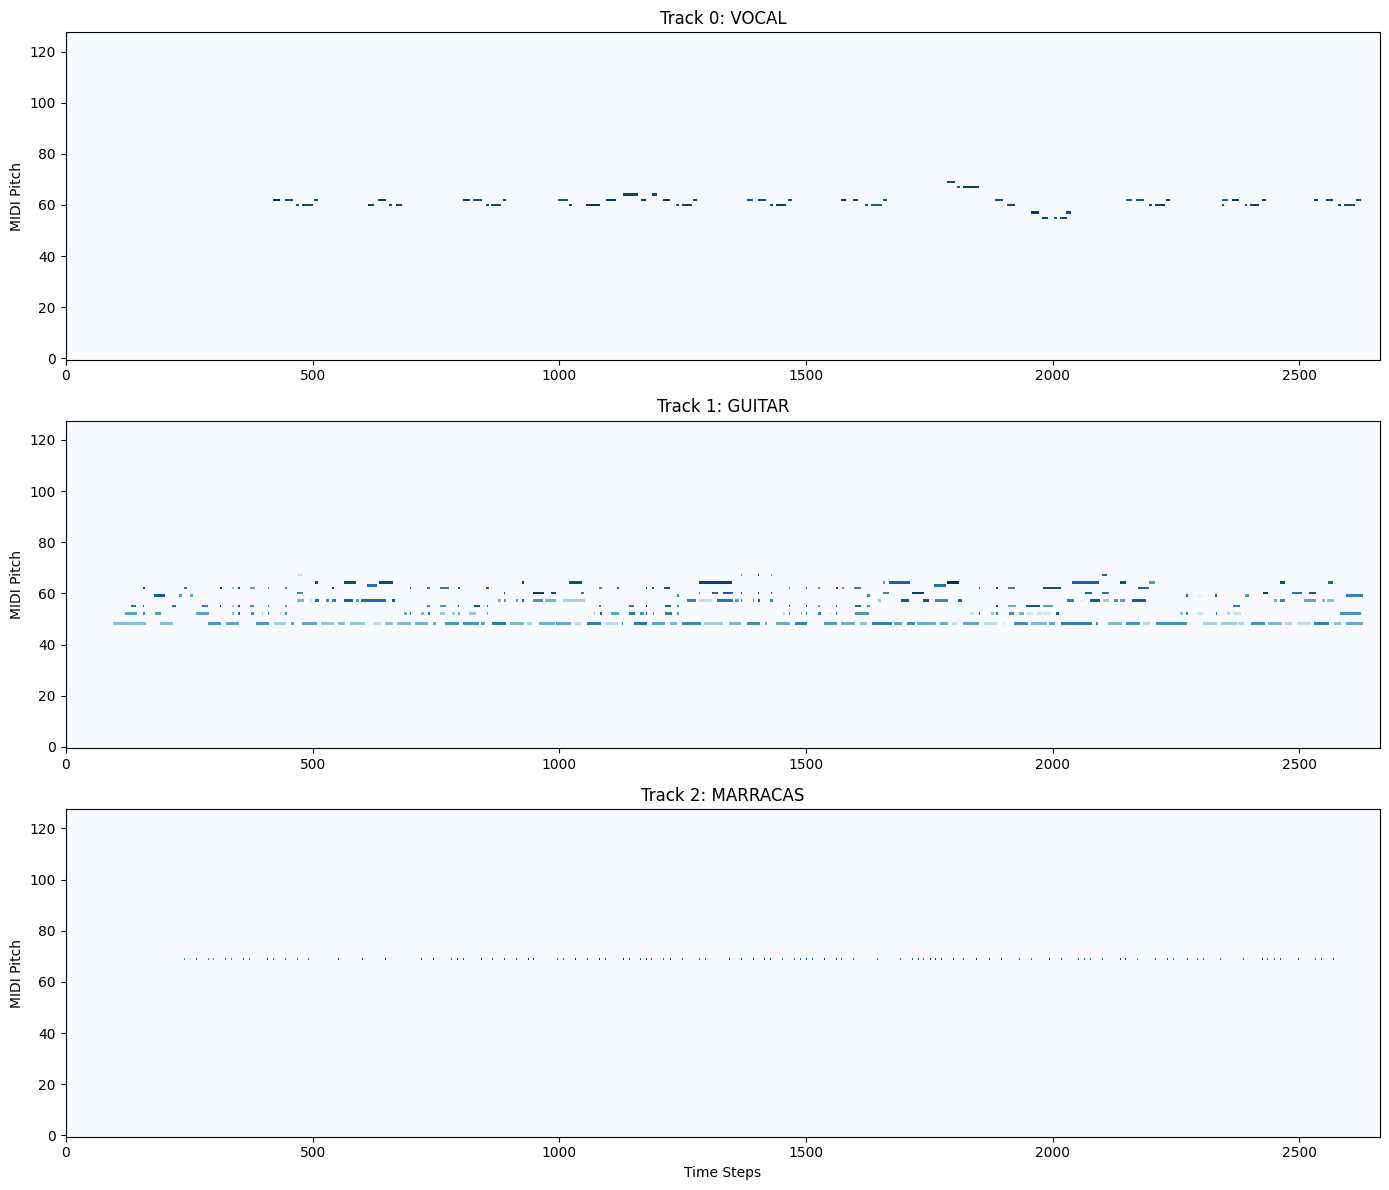

In [11]:
# Visualize the first few tracks
fig, axes = plt.subplots(
    min(len(multitrack.tracks), 3), 1, figsize=(14, 4 * min(len(multitrack.tracks), 3))
)

if len(multitrack.tracks) == 1:
    axes = [axes]

for i, (track, ax) in enumerate(zip(multitrack.tracks[:3], axes)):
    # Plot piano roll
    pianoroll = track.pianoroll.T  # Transpose for plotting

    # Downsample for visualization if needed
    if pianoroll.shape[1] > 2000:
        step = pianoroll.shape[1] // 2000
        pianoroll = pianoroll[:, ::step]

    ax.imshow(
        pianoroll, aspect="auto", origin="lower", cmap="Blues", interpolation="nearest"
    )
    ax.set_ylabel("MIDI Pitch")
    ax.set_title(f"Track {i}: {track.name or 'Unnamed'}")

    if i == len(axes) - 1:
        ax.set_xlabel("Time Steps")

plt.tight_layout()
plt.show()

In [12]:
def analyze_pianoroll(pianoroll):
    """Extract features from a piano roll matrix"""
    features = {}

    # Temporal features
    features["num_time_steps"] = pianoroll.shape[0]
    features["active_time_steps"] = (pianoroll.sum(axis=1) > 0).sum()
    features["density"] = features["active_time_steps"] / features["num_time_steps"]

    # Pitch features
    pitch_histogram = pianoroll.sum(axis=0)
    active_pitches = np.where(pitch_histogram > 0)[0]

    if len(active_pitches) > 0:
        features["pitch_range"] = active_pitches.max() - active_pitches.min()
        features["num_unique_pitches"] = len(active_pitches)
        features["mean_pitch"] = np.average(
            active_pitches, weights=pitch_histogram[active_pitches]
        )

    # Polyphony
    notes_per_timestep = pianoroll.sum(axis=1)
    features["mean_polyphony"] = notes_per_timestep.mean()
    features["max_polyphony"] = notes_per_timestep.max()

    return features


# Analyze each track
print("Track analysis:")
for i, track in enumerate(multitrack.tracks):
    if track.pianoroll.sum() > 0:  # Only analyze non-empty tracks
        features = analyze_pianoroll(track.pianoroll)
        print(f"\nTrack {i}: {track.name or 'Unnamed'}")
        for key, value in features.items():
            print(
                f"  {key}: {value:.2f}"
                if isinstance(value, float)
                else f"  {key}: {value}"
            )


Track analysis:

Track 0: VOCAL
  num_time_steps: 2664
  active_time_steps: 790
  density: 0.30
  pitch_range: 14
  num_unique_pitches: 7
  mean_pitch: 61.31
  mean_polyphony: 30.34
  max_polyphony: 199

Track 1: GUITAR
  num_time_steps: 2664
  active_time_steps: 2187
  density: 0.82
  pitch_range: 19
  num_unique_pitches: 10
  mean_pitch: 54.64
  mean_polyphony: 90.24
  max_polyphony: 366

Track 2: MARRACAS
  num_time_steps: 2664
  active_time_steps: 198
  density: 0.07
  pitch_range: 0
  num_unique_pitches: 1
  mean_pitch: 69.00
  mean_polyphony: 7.80
  max_polyphony: 127

Track 3: CLAVES
  num_time_steps: 2664
  active_time_steps: 59
  density: 0.02
  pitch_range: 0
  num_unique_pitches: 1
  mean_pitch: 75.00
  mean_polyphony: 1.35
  max_polyphony: 77

Track 4: CONGA
  num_time_steps: 2664
  active_time_steps: 154
  density: 0.06
  pitch_range: 0
  num_unique_pitches: 1
  mean_pitch: 63.00
  mean_polyphony: 4.40
  max_polyphony: 116

Track 5: LOS PARANOIAS
  num_time_steps: 2664
  a

In [13]:
# Pypianoroll allows easy resampling to different time resolutions
original_resolution = multitrack.resolution
print(f"Original resolution: {original_resolution} ticks per quarter note")

# Resample to a different resolution (e.g., 24 for 16th notes at 4/4)
resampled = multitrack.copy()
resampled.set_resolution(24)

print(f"Resampled resolution: {resampled.resolution} ticks per quarter note")
print(f"Original length: {len(multitrack)} time steps")
print(f"Resampled length: {len(resampled)} time steps")

Original resolution: 24 ticks per quarter note
Resampled resolution: 24 ticks per quarter note
Original length: 7 time steps
Resampled length: 7 time steps


In [ ]:
# Convert to binary (onset) representation
if multitrack.tracks:
    track = multitrack.tracks[0]

    # Original piano roll (with velocities)
    original = track.pianoroll

    # Binary piano roll (just note presence)
    binary = (original > 0).astype(np.uint8)

    print(f"Original value range: {original.min()} - {original.max()}")
    print(f"Binary value range: {binary.min()} - {binary.max()}")
    print(
        f"Number of active notes - Original: {(original > 0).sum()}, Binary: {binary.sum()}"
    )


Original value range: 0 - 111
Binary value range: 0 - 1
Number of active notes - Original: 796, Binary: 796


In [ ]:
# Create a simple two-track piece
resolution = 24  # 24 ticks per quarter note
tempo = 120.0

# Create melody track (C major arpeggio)
melody_roll = np.zeros((96, 128), dtype=np.uint8)  # 4 bars in 4/4
melody_notes = [60, 64, 67, 72]  # C, E, G, C
for i, note in enumerate(melody_notes * 4):  # Repeat 4 times
    start = i * 6  # Each note is a quarter note (24/4 = 6 ticks)
    melody_roll[start : start + 6, note] = 100  # Velocity 100

melody_track = pypianoroll.Track(
    name="Melody",
    program=0,  # Acoustic Grand Piano
    is_drum=False,
    pianoroll=melody_roll,
)

# Create bass track
bass_roll = np.zeros((96, 128), dtype=np.uint8)
bass_notes = [48, 52]  # C, E (an octave lower)
for i, note in enumerate(bass_notes * 8):  # Repeat 8 times
    start = i * 12  # Each note is a half note
    bass_roll[start : start + 12, note] = 80

bass_track = pypianoroll.Track(
    name="Bass",
    program=32,  # Acoustic Bass
    is_drum=False,
    pianoroll=bass_roll,
)

# Create multitrack
new_multitrack = pypianoroll.Multitrack(
    resolution=resolution, tempo=tempo, tracks=[melody_track, bass_track]
)

# Save
output_path = MIDI_DATASET_PATH / "simple_composition.mid"
pypianoroll.write(str(output_path), new_multitrack)
print(f"Created new multi-track MIDI file: {output_path}")

# Visualize
fig, axes = plt.subplots(2, 1, figsize=(12, 6))
for i, (track, ax) in enumerate(zip(new_multitrack.tracks, axes)):
    ax.imshow(
        track.pianoroll.T,
        aspect="auto",
        origin="lower",
        cmap="Blues",
        interpolation="nearest",
    )
    ax.set_title(f"{track.name}")
    ax.set_ylabel("MIDI Pitch")
    if i == 1:
        ax.set_xlabel("Time Steps")

plt.tight_layout()
plt.show()